<a href="https://colab.research.google.com/github/italati/AI-Deep-Learning-Lab-2022/blob/it-nb-0/sessions/ct-body-part/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Automatic Labeling of Body CT Images

### In this session, we will explore how we can utilize a trained machine learning algorithm to automatically predict chest, abdomen, or pelvic slices from a body CT.

*The algorithm utilized in this notebook was developed by Ian Pan, MD. ai, and modified by Anouk Stein, MD.ai and Ross Filice MD, MedStar Georgetown University Hospital. The training code can be found [here.](https://github.com/RSNA/AI-Deep-Learning-Lab-2022/blob/main/sessions/ct-body-part/train.ipynb)*


## Acquire Data and Trained Model

In [20]:
!git clone https://github.com/rwfilice/bodypart.git

fatal: destination path 'bodypart' already exists and is not an empty directory.


## Install Packages

Google Colab comes preloaded with several packages that we can use but does not include everything. Pydicom is a package that will allow us to read, modify, and write DICOM data easily in python. We will install it here.

In [21]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Python packages


In [22]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import matplotlib.pyplot as plt
import pandas as pd
from keras import activations
from keras.applications.mobilenet_v2 import MobileNetV2
import numpy as np
from keras.layers import Dropout, Dense, GlobalAveragePooling2D
from keras import Model
from tensorflow import keras
import cv2
from pathlib import Path
import re
from scipy.ndimage.interpolation import zoom
from keras.models import load_model
from keras.applications.imagenet_utils import preprocess_input
from sklearn.manifold import TSNE
import seaborn as sns
import sys
sys.path.insert(0,'/content/bodypart/')
from saliency import *

np.set_printoptions(suppress=True,threshold=3)

## Load and Scale Test Images
Here we will create a list of the path to the images that we will eventually input to our model for prediction. 

We will use the glob function in the glob module to create a list with the **pathname** of all our test images using a specific pattern. 

In [23]:
#Provide path to test images
testPath = Path('bodypart/testnpy')
testList = list(sorted(testPath.glob('**/*.npy'), key=lambda fn: int(re.search('-([0-9]*)', str(fn)).group(1))))

In [24]:
testList

[PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-1.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-2.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-3.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-4.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-5.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-6.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-7.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-8.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-9.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-10.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-11.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-12.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-13.npy'),
 PosixPath('bodypart/testnpy/d2bb80e260ba5cd45aaaba9617f40f0d-14.npy'),
 

Now that we have a list of our test images, we need to define two functions. The first function will load the DICOM image array from the stored numpy file, and the second function will convert the DICOM image array into an 8 bit image using a specific window width and level. We will use these functions to load and process our images before feeding them into our model.

In [25]:
def get_dicom_and_uid(path_to_npy):
    '''
    Given a filepath, return the npy file and corresponding SOPInstanceUID. 
    '''
    path_to_npy = str(path_to_npy)
    dicom_file = np.load(path_to_npy)
    uid = path_to_npy.split('/')[-1].replace('.npy', '')
    return dicom_file, uid

In [26]:
def convert_dicom_to_8bit(npy_file, width, level, imsize=(224.,224.), clip=True): 
    '''
    Given a DICOM file, window specifications, and image size, 
    return the image as a Numpy array scaled to [0,255] of the specified size. 
    '''
    array = npy_file.copy() 
    #array = array + int(dicom_file.RescaleIntercept) #we did this on preprocess
    #array = array * int(dicom_file.RescaleSlope) #we did this on preprocess
    array = np.clip(array, level - width / 2, level + width / 2)
    # Rescale to [0, 255]
    array -= np.min(array) 
    array /= np.max(array) 
    array *= 255.
    array = array.astype('uint8')
    
    if clip:
    # Sometimes there is dead space around the images -- let's get rid of that
        nonzeros = np.nonzero(array) 
        x1 = np.min(nonzeros[0]) ; x2 = np.max(nonzeros[0])
        y1 = np.min(nonzeros[1]) ; y2 = np.max(nonzeros[1])
        array = array[x1:x2,y1:y2]

    # Resize image if necessary
    resize_x = float(imsize[0]) / array.shape[0] 
    resize_y = float(imsize[1]) / array.shape[1] 
    if resize_x != 1. or resize_y != 1.:
        array = zoom(array, [resize_x, resize_y], order=1, prefilter=False)
    return np.expand_dims(array, axis=-1)

## Load our stored model and trained weights

In order to recreate our model to make inferences, we will load our stored model architecture and its pre-trained weights. The model is stored in JSON format and it's weights are stored in a H5 file.

In [27]:
from keras.models import model_from_json
json_file = open('bodypart/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

In [28]:
model.load_weights('bodypart/tcga-mguh-multilabel.h5')  #federated

# Predict
Now we will define a function that will allow us to load and process our test images, and subsequently feed them into our classification model.

In [29]:
#Inference
IMSIZE = 256
WINDOW_LEVEL, WINDOW_WIDTH = 50, 500
def predict(model, images, imsize):
    '''
    Small modifications to data generator to allow for prediction on test data.
    '''
    test_arrays = [] 
 
    test_probas = [] 
    test_uids   = []
    for im in images: 
        dicom_file, uid = get_dicom_and_uid(im) 
        try:
            array = convert_dicom_to_8bit(dicom_file, WINDOW_WIDTH, WINDOW_LEVEL, 
                                    imsize=(imsize,imsize))
        except: 
            continue
      
        array = preprocess_input(array, mode='tf')
        test_arrays.append(array) 

        test_probas.append(model.predict(np.expand_dims(array, axis=0)))
        test_uids.append(uid)
    return test_uids, test_arrays, test_probas
                                    

When we run this cell, we use the function we defined above to predict and store our results in three separate lists. 

The uids list contains the unique identifier for each DICOM slice, the X list contains an array of image pixel data for each slice, and the y_prob list contains an array containing the prediction for each slice.

In [30]:
uids, X, y_prob = predict(model, testList, IMSIZE)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


We will then store this information into a pandas dataframe, which is a tabular data structure.

In [31]:
test_pred_df = pd.DataFrame({'uid': uids, 'X': X, 'y_prob': y_prob})
test_pred_df

,uid,X,y_prob
0,d2bb80e260ba5cd45aaaba9617f40f0d-1,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.9951313, 0.028154716, 5.2609517e-05]]"
1,d2bb80e260ba5cd45aaaba9617f40f0d-2,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.9886256, 0.0181551, 0.001550393]]"
2,d2bb80e260ba5cd45aaaba9617f40f0d-3,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.9746267, 0.021493535, 0.0022077996]]"
3,d2bb80e260ba5cd45aaaba9617f40f0d-4,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.97096574, 0.019585626, 0.0014411865]]"
4,d2bb80e260ba5cd45aaaba9617f40f0d-5,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.9872248, 0.006829163, 0.0013882628]]"
...,...,...,...
211,d2bb80e260ba5cd45aaaba9617f40f0d-212,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.0140901245, 0.002003133, 0.98827446]]"
212,d2bb80e260ba5cd45aaaba9617f40f0d-213,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.009450613, 0.00062626967, 0.99483424]]"
213,d2bb80e260ba5cd45aaaba9617f40f0d-214,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.003277148, 0.00041210002, 0.99752456]]"
214,d2bb80e260ba5cd45aaaba9617f40f0d-215,"[[[-1.0], [-1.0], [-1.0], [-1.0], [-1.0], [-1....","[[0.0018993871, 0.00013068292, 0.9983763]]"


## Visualizing Our Results

This cell will create three separate arrays from the "y_prob" column from the pandas dataframe. The y_prob column contains an array for each image with three separate probabilities (one for each class: chest, abdomen, and pelvis). We will store each in a separate array called chest, abd, and pelv.

In [32]:
test_pred_df.apply(lambda row: row['y_prob'], axis=1)

0       [[0.9951313, 0.028154716, 5.2609517e-05]]
1           [[0.9886256, 0.0181551, 0.001550393]]
2        [[0.9746267, 0.021493535, 0.0022077996]]
3       [[0.97096574, 0.019585626, 0.0014411865]]
4        [[0.9872248, 0.006829163, 0.0013882628]]
                          ...                    
211     [[0.0140901245, 0.002003133, 0.98827446]]
212    [[0.009450613, 0.00062626967, 0.99483424]]
213    [[0.003277148, 0.00041210002, 0.99752456]]
214    [[0.0018993871, 0.00013068292, 0.9983763]]
215    [[0.0029323285, 0.00023197688, 0.9978391]]
Length: 216, dtype: object

In [33]:
chest = np.stack(test_pred_df['y_prob'])[:,0][:,0]
abd = np.stack(test_pred_df['y_prob'])[:,0][:,1]
pelv = np.stack(test_pred_df['y_prob'])[:,0][:,2]

chest, abd, pelv

(array([0.9951313 , 0.9886256 , 0.9746267 , ..., 0.00327715, 0.00189939,
        0.00293233], dtype=float32),
 array([0.02815472, 0.0181551 , 0.02149354, ..., 0.0004121 , 0.00013068,
        0.00023198], dtype=float32),
 array([0.00005261, 0.00155039, 0.0022078 , ..., 0.99752456, 0.9983763 ,
        0.9978391 ], dtype=float32))

Now we can plot these arrays on a graph.

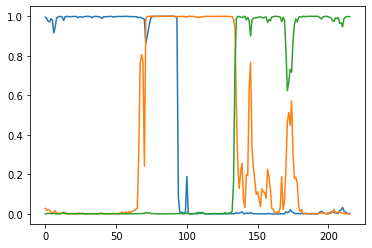

In [34]:
plt.plot(chest)
plt.plot(abd)
plt.plot(pelv)

In [35]:
numaveslices = 5
avepreds = []
allpreds = np.stack(test_pred_df['y_prob'])[:,0]
for idx,arr in enumerate(allpreds):
    low = int(max(0,idx-(numaveslices-1)/2))
    high = int(min(len(allpreds),idx+(numaveslices+1)/2))
    avepreds.append(np.mean(allpreds[low:high],axis=0))

chest = np.stack(avepreds)[:,0]
abd = np.stack(avepreds)[:,1]
pelv = np.stack(avepreds)[:,2]

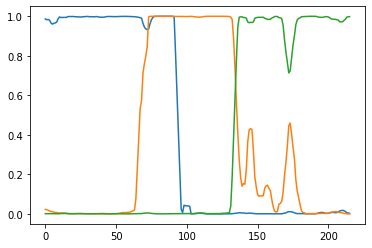

In [36]:
#averaged over 5 slices
plt.plot(chest)
plt.plot(abd)
plt.plot(pelv)

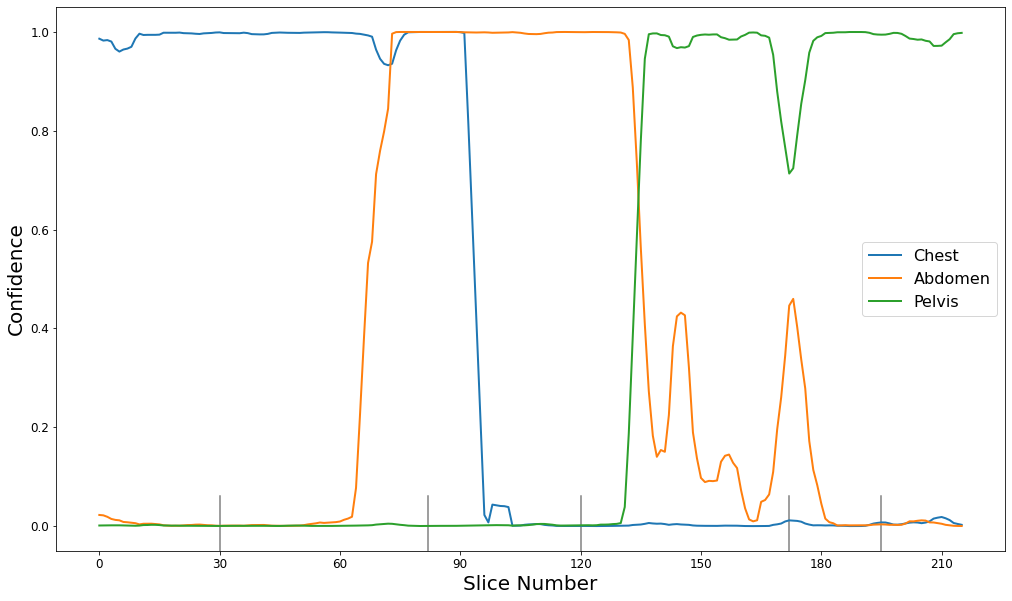

In [37]:
#averaged over 5 slices
fig, ax1 = plt.subplots(figsize=(17,10))
ax1.set_xlabel("Slice Number", fontsize=20)
ax1.set_ylabel("Confidence", fontsize=20)
plt.xticks([0,30,60,90,120,150,180,210],fontsize=12)
plt.yticks(fontsize=12)
ax1.axvline(30,color='gray',ymax=0.1)
ax1.axvline(82,color='gray',ymax=0.1)
ax1.axvline(120,color='gray',ymax=0.1)
ax1.axvline(172,color='gray',ymax=0.1)
ax1.axvline(195,color='gray',ymax=0.1)
plt.plot(chest,linewidth=2,label="Chest")
plt.plot(abd,linewidth=2,label="Abdomen")
plt.plot(pelv,linewidth=2,label="Pelvis")
plt.legend(fontsize=16)

Lets take a look at our images to see how our model is doing.

In [38]:
def displayImages(imgs,labels):
    numimgs = len(imgs)
    plt.figure(figsize=(20,10))
    for idx,img in enumerate(imgs):
        dicom_file, uid = get_dicom_and_uid(img)
        img = convert_dicom_to_8bit(dicom_file, WINDOW_WIDTH, WINDOW_LEVEL, clip=False)
        plt.subplot("1%i%i" % (numimgs,idx+1))
        plt.imshow(img[...,0],cmap='gray')
        plt.title(labels[idx])
        plt.axis('off')

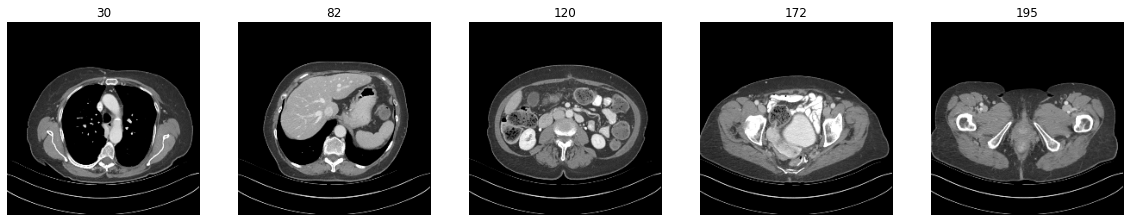

In [39]:
displayImages([testList[30],testList[82],testList[120],testList[172],testList[195]],[30,82,120,172,195])

## Gradient activated class activation maps / Bounding Boxes

A technique for making Convolutional Neural Network (CNN) based models more transparent by visualizing the regions of input that are “important” for predictions from these models.

From a high-level, we take an image as input and create a model that is cut off at the layer for which we want to create a Grad-CAM heat-map. We attach the fully-connected layers for prediction. We then run the input through the model, grab the layer output, and loss. Next, we find the gradient of the output of our desired model layer w.r.t. the model loss. From there, we take sections of the gradient which contribute to the prediction, reduce, resize, and rescale so that the heat-map can be overlaid with the original image.

In [40]:
model.summary()
print(len(model.layers))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  288         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [41]:
layer_idx = 156 #Index of last layer
penultimate_layer=151 #Index of last convolutional layer
#model.layers[-1].activation = activations.linear #Make the last layer linear (don't need to, since the last layer is already linear (Dense))
model.save('bodypart/grad_cm_5.hdf5')

In [42]:
model_gradcam = load_model('bodypart/grad_cm_5.hdf5')
model_gradcam = apply_modifications(model_gradcam)  
#Applies modifications to the model layers to create a new graph.

In [43]:
N_CLASSES  = 3

labels_dict1 = {'Chest':0, 
               'Abdomen':1,
               'Pelvis':2}
#mapping of labels to index

labels_dict2 = {0:'Chest', 
               1:'Abdomen',
               2:'Pelvis'}
#mapping of index to labels
N_CLASSES = len(labels_dict1)

In [44]:
def displayImages_saliency_maps(imgs,labels):
    numimgs = len(imgs)
    plt.figure(figsize=(20,10))
    for idx,img in enumerate(imgs):
        dicom_file, uid = get_dicom_and_uid(img)
        img = convert_dicom_to_8bit(dicom_file, WINDOW_WIDTH, WINDOW_LEVEL, 
                            imsize=(IMSIZE,IMSIZE))
        
        array = preprocess_input(img, mode='tf')
        probs = model.predict(np.expand_dims(array, axis=0)) #Do prediction on the given input image
        index = np.argmax(probs)
        final_pred = labels_dict2[np.argmax(probs)] #Find the label of the prediction
        saliency_map = visualize_cam(model_gradcam, layer_idx , filter_indices=index, seed_input=array,
                              penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=None,grad_modifier=None) #Get the saliency maps of the prediction
        
        saliency_map = (saliency_map-saliency_map.min())/(saliency_map.max()-saliency_map.min())
        heatmap = np.uint8(cm.jet(saliency_map[...,0])[..., :3] * 255)
        original = np.uint8(cm.gray(img[...,0])[..., :3] * 255)

        #Overlay the saliency map on the input image
        overlaid_image = overlay(heatmap, original,0.2)
    
        plt.subplot("1%i%i" % (numimgs,idx+1))
        plt.imshow(overlaid_image)
        plt.title(f'{final_pred}:{probs[0][index]}')
        plt.axis('off')

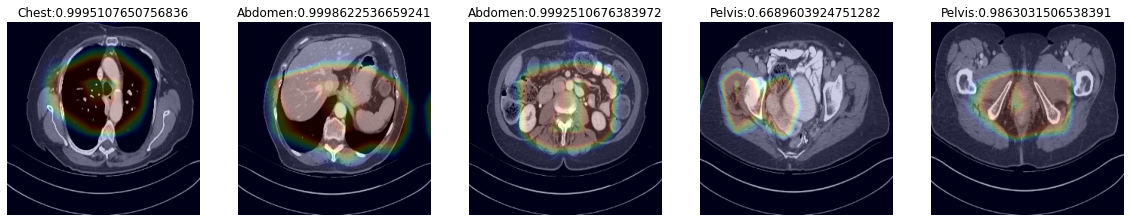

In [45]:
displayImages_saliency_maps([testList[30],testList[82],testList[120],testList[172],testList[195]],[30,82,120,172,195])

In [46]:
def displayImages_with_bbox(imgs,labels):
    numimgs = len(imgs)
    plt.figure(figsize=(20,10))
    for idx,img in enumerate(imgs):
        dicom_file, uid = get_dicom_and_uid(img)
        img = convert_dicom_to_8bit(dicom_file, WINDOW_WIDTH, WINDOW_LEVEL, 
                            imsize=(IMSIZE,IMSIZE))
        
        array = preprocess_input(img, mode='tf')
        probs = model.predict(np.expand_dims(array, axis=0)) #Do prediction on the given input image
        indice = np.argmax(probs)
        final_pred = labels_dict2[np.argmax(probs)] #Find the label of the prediction
        saliency_map = visualize_cam(model_gradcam, layer_idx , filter_indices=indice, seed_input=array,
                              penultimate_layer_idx=penultimate_layer,
                              backprop_modifier=None,grad_modifier=None)#Get the saliency maps of the prediction
        gray = saliency_map[...,0] #Extract the red channel of the saliency map given highest prediction region
        thresh = (gray>100).astype('uint8') #Threshold and extract the roi
        cnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) #Find the bounding boxes of the heatmap roi
        temp = img.copy()
        temp = np.concatenate([temp,temp,temp],2)
        
        max_area = 0
        i = 0
        for index,c in enumerate(cnts):
            if cv2.contourArea(c)>max_area:
                max_area = cv2.contourArea(c)
                i = index
                
        rect = cv2.boundingRect(cnts[i])
        x,y,w,h = rect
        temp = cv2.rectangle(temp,(x,y),(x+w,h+y),(255,0,0),6)      
    
        plt.subplot("1%i%i" % (numimgs,idx+1))
        plt.imshow(temp)
        plt.title(f'{final_pred}:{probs[0][indice]}')
        plt.axis('off')

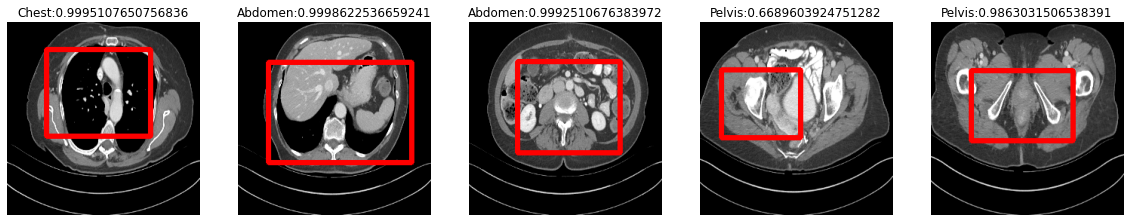

In [47]:
displayImages_with_bbox([testList[30],testList[82],testList[120],testList[172],testList[195]],[30,82,120,172,195])

## Data Exploration using T-SNE



t-Distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction technique used to represent high-dimensional dataset in two or three dimensions so that we can visualize it.

At a high level, t-SNE constructs a probability distribution for the high-dimensional samples in such a way that similar samples have a high likelihood of being picked while dissimilar points have an extremely small likelihood of being picked. Then, t-SNE defines a similar distribution for the points in the low-dimensional embedding. Finally, t-SNE minimizes the Kullback–Leibler divergence between the two distributions with respect to the locations of the points in the embedding.

In [48]:
#Get path of train images

trainPath = Path('bodypart/npy')
trainList = list(sorted(trainPath.glob('**/*.npy'), key=lambda fn: int(re.search('-([0-9]*)', str(fn)).group(1))))
len(trainList)

4359

In [49]:
#Stores the uids and their processed input images
uids, X, k= predict(model, trainList, IMSIZE)

In [50]:
X_new = np.array(X)
X_new = X_new.squeeze()
#Reshape all the processed input images to 2 dimensional array
X_new = X_new.reshape(X_new.shape[0],X_new.shape[1]*X_new.shape[2])

In [51]:
#Get the labels/ground truths of the input images

df = pd.read_csv("bodypart/labels.csv")
Y = [] 
for i in range(len(trainList)):
    label = labels_dict1[df[df['npyid']==str(trainList[i]).split('/')[-1].split('.')[0]]['label'].values[0]]
    Y.append(label)

In [52]:
#Randomly shuffle the order of input images
np.random.seed(42)
perm = np.random.permutation(X_new.shape[0])
Y_new = np.array(Y)

In [53]:
X_new.shape,Y_new.shape

((4359, 65536), (4359,))

In [54]:
#x_new = X_new #If you want all points
#y_new = Y_new #If you want all points

x_new = X_new[perm][:3000] #Select random 3000 samples
y_new = Y_new[perm][:3000] #Select random 3000 samples

In [55]:
#Plot t-sne 

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x_new) 

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.239s...
[t-SNE] Computed neighbors for 4000 samples in 48.637s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 48.563524
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.064392
[t-SNE] KL divergence after 1000 iterations: 0.660743


In [56]:
df = pd.DataFrame()
df["y"] = y_new
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]
df = df.replace({'y':labels_dict2})
print(df['y'].value_counts())

Pelvis     1517
Chest      1263
Abdomen    1220
Name: y, dtype: int64


[Text(0.5, 1.0, 'T-SNE')]

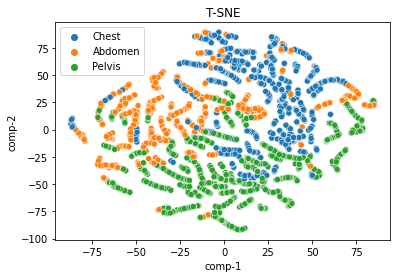

In [57]:
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                data=df).set(title="T-SNE") 

## References

[1] Selvaraju, R. R., Cogswell, M., Das, A., Vedantam, R., Parikh, D. & Batra, D. (2017). Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization.. ICCV (p./pp. 618-626), : IEEE Computer Society. ISBN: 978-1-5386-1032-9

[2] van der Maaten, L. & Hinton, G. (2008). Visualizing Data using t-SNE . Journal of Machine Learning Research, 9, 2579--2605.

